In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d

df = pd.read_csv('deltas.csv')

[ 0.          4.67342518  9.82924313 15.04325199 19.82009831 23.73653638
 26.56290177 28.27634906 29.01735628 29.00276734 28.45060298 27.54685224
 26.43416143 25.21303208 23.94846412 22.67912224 21.42923593 20.21279646
 19.03903766 17.90309276 16.76340137 15.60890084 14.48709384 13.4846015
 12.73848004] [ 0.          4.6288799   9.76607978 14.99003493 19.7996533  23.75344477
 26.60167565 28.32013549 29.0470149  29.00978649 28.43366029 27.51295467
 26.39573853 25.18818787 23.9570343  22.74723907 21.58320785 20.47937637
 19.44228842 18.47261979 17.56878935 16.72783858 15.94689178 15.22228189
 14.55000737] [ 0.         -0.04454529 -0.06316335 -0.05321706 -0.02044501  0.01690838
  0.03877388  0.04378643  0.02965863  0.00701915 -0.01694269 -0.03389757
 -0.0384229  -0.02484421  0.00857018  0.06811683  0.15397192  0.26657991
  0.40325076  0.56952703  0.80538798  1.11893774  1.45979794  1.73768039
  1.81152733]


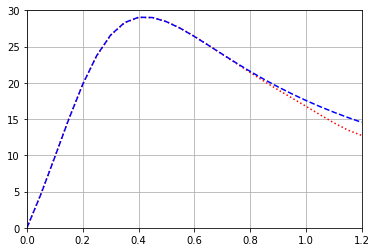

In [8]:
#Initialize some global variable, used by all subsequent function
sd = df.query('Layout == 5 & Wing == 0 & Span == 0.25')
deflection = np.arange(-10,12,2)
Mz = np.zeros_like(deflection, dtype = float)
Cx = np.zeros_like(deflection, dtype = float)
Cy = np.arange(0,1.25,0.05)
dV = np.zeros_like(Cy, dtype = float)


#Function that return array of Mz = f(dV) values correspond at specific Cy (one point)
def getMzDv(Cy_point, sd):
    for i in np.ndenumerate(deflection):
        sd1 = sd.loc[(sd['dV'] == i[1])]
        Mz_1 = np.flip(sd1.iloc[:]['Mz'].values,0)
        Cy_1 = np.flip(sd1.iloc[:]['Cy'].values,0)
        Mz[i[0]] = sp.interpolate.interp1d(Cy_1, Mz_1, kind = 'quadratic',
                                          bounds_error = False, fill_value = 'extrapolate')(Cy_point)
    return Mz

#Function that return array of dV = f(Cy) values at specific Cy (array) with zero Mz condition
def getDvCy(Cy_arr, sd):
    for j in np.ndenumerate(Cy_arr):
        Mz_2 = getMzDv(Cy_arr[j[0]], sd)
        dV[j[0]] = sp.interpolate.interp1d(Mz_2, deflection, kind = 'quadratic',
                                          bounds_error = False, fill_value = 'extrapolate')(0)
    return dV

#Function, that return array of Cx = f(dV) values correspond at specific Cy (one point)
def getCxDv(Cy_point, sd):
    for i in np.ndenumerate(deflection):
        sd2 = sd.loc[(sd['dV'] == i[1])]
        Cx_1 = np.flip(sd2.iloc[:]['Cx'].values,0)
        Cy_1 = np.flip(sd2.iloc[:]['Cy'].values,0)
        Cx[i[0]] = sp.interpolate.interp1d(Cy_1, Cx_1, kind = 'quadratic',
                                          bounds_error = False, fill_value = 'extrapolate')(Cy_point)
    return Cx    

#Function that return array of Cx = f(Cy) values at specific Cy (array) with zero Mz condition
def getDvCx(Cy_arr, dV_arr, sd):
    Cx_arr = np.zeros_like(Cy_arr, dtype = float)
    for j in np.ndenumerate(Cy_arr):
        Cx_2 = getCxDv(Cy_arr[j[0]],sd)
        Cx_arr[j[0]] = sp.interpolate.interp1d(deflection, Cx_2, kind = 'quadratic',
                                               bounds_error = False, fill_value = 'extrapolate')(dV_arr[j[0]])
    return Cx_arr

#Function that return array of Cx = f(Cy) values at specific Cy (array) with zero dV deflection
def getDvCxZero(Cy_arr, sd):
    sd3 = sd.loc[(sd['dV'] == 0)]
    Cx_3 = np.flip(sd3.iloc[:]['Cx'].values,0)
    Cy_3 = np.flip(sd3.iloc[:]['Cy'].values,0)
    Cx_arr_0 = np.zeros_like(Cy_arr, dtype = float)
    Cx_arr_0 = sp.interpolate.interp1d(Cy_3, Cx_3, kind = 'quadratic',
                                       bounds_error = False, fill_value = 'extrapolate')(Cy_arr)
    return Cx_arr_0

#Obtain data
dV = getDvCy(Cy,sd)
K1 = Cy/getDvCx(Cy,dV,sd)
K2 = Cy/getDvCxZero(Cy,sd)
dK = K2-K1
#Print and Plot
print(K1.T,K2.T,dK.T)
ax = plt.gca()
ax.grid()
ax.set_xlim(0,1.2)
ax.set_ylim(0,30)
plt.plot(Cy,K1,':r')
plt.plot(Cy,K2,'--b')
plt.show()